Analysis for enriched versus non-enriched TRBVs

Last Updated on: Nov 15, 2024

In [1]:
import sys

#Import libraries
#import scanorama
import time
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import copy
import itertools
import seaborn as sns
import math

from scipy.stats import fisher_exact

import pandas as pd
from itertools import combinations
from scipy.stats import sem
import scipy.stats as stats
import statsmodels.stats.multitest
from scipy.stats.mstats import gmean

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)


sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.4.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.2.1
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.3
numpy               1.22.4
packaging           20.9
pandas              1.2.3
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptyprocess          0.7.0
pygments            2.8.0
pyparsing           2.4.7
pytz                2021.1
scanp

## Remove cells with no TRBV annotation

In [2]:
adata = sc.read('adata_object/adata_only_T_cells.h5ad')
adata

AnnData object with n_obs × n_vars = 99074 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
adata = adata[adata.obs['TRBV'] != 'None']

/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
adata.obs['subgroup']

index
AAACCTGAGAATGTGT-1-0    SKG_High
AAACCTGAGACCTAGG-1-0    SKG_High
AAACCTGAGACGCACA-1-0    SKG_High
AAACCTGAGACTAGAT-1-0    SKG_High
AAACCTGAGCCACGTC-1-0    SKG_High
                          ...   
TTTGTCATCCACGAAT-1-7      WT_Low
TTTGTCATCTCCAACC-1-7      WT_Low
TTTGTCATCTGGCGTG-1-7      WT_Low
TTTGTCATCTTGCATT-1-7      WT_Low
TTTGTCATCTTTAGTC-1-7      WT_Low
Name: subgroup, Length: 81778, dtype: category
Categories (4, object): ['WT_Low', 'WT_High', 'SKG_Low', 'SKG_High']

# Differential expression Nr4a1 high cluster TRBV enriched WT High versus SKG High

In [4]:
adata_df = adata[adata.obs['cell_types'] == '3']
sag_trbv = ['TRBV26', 'TRBV12-1', 'TRBV15', 'TRBV16','TRBV3', 'TRBV29']
adata_df.obs['trbv_enriched'] = ['Enriched' if y in sag_trbv else 'Not enriched' for y in adata_df.obs['TRBV']]
adata_df_skg = adata_df[adata_df.obs['subgroup'] == 'SKG_High']
adata_df_skg

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 1644 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb', 'trbv_enriched'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
np.unique(adata_df.obs['subgroup'], return_counts = True)

(array(['SKG_High', 'SKG_Low', 'WT_High', 'WT_Low'], dtype=object),
 array([1644,  265, 2370,  661]))

In [5]:
adata_df_enriched = adata_df[[x in ['SKG_High','WT_High'] and y == 'Enriched' for x,y in zip(adata_df.obs['subgroup'],adata_df.obs['trbv_enriched'])]]

In [ ]:
adata_df_not_enriched = adata_df[[x in ['SKG_High','WT_High'] and y == 'Not enriched' for x,y in zip(adata_df.obs['subgroup'],adata_df.obs['trbv_enriched'])]]
print(np.unique(adata_df_not_enriched.obs['subgroup'], return_counts = True))
adata_df_not_enriched

In [9]:
adata_df_enriched

View of AnnData object with n_obs × n_vars = 534 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb', 'trbv_enriched'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
np.unique(adata_df_enriched.obs['subgroup'], return_counts = True)

(array(['SKG_High', 'WT_High'], dtype=object), array([289, 245]))

In [6]:
sc.tl.rank_genes_groups(adata_df_enriched, 'subgroup', n_genes = len(adata_df_enriched.raw.var_names), use_raw=True, groups='all',
                           reference='rest', rankby_abs=False, key_added=None,
                           copy=False, method='wilcoxon',
                           corr_method='benjamini-hochberg', log_transformed=True, pts = True)

ranking genes
/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'trbv_enriched' as categorical
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [8]:
percent_df = adata_df_enriched.uns['rank_genes_groups']['pts']
cluster = 'WT_High'

result_gene_names =  np.array(adata_df_enriched.uns['rank_genes_groups']['names'][cluster])
result_log_changes = np.array(adata_df_enriched.uns['rank_genes_groups']['logfoldchanges'][cluster])
result_p_values = np.array(adata_df_enriched.uns['rank_genes_groups']['pvals_adj'][cluster])
result_df = pd.DataFrame.from_dict({'gene':result_gene_names,'logfoldchange':result_log_changes, 'adj_p_value':result_p_values})
result_df.index = result_df['gene']
result_df['WT_High_percent'] = list(percent_df.loc[result_df.index,:]['WT_High'])
result_df['SKG_High_percent'] = list(percent_df.loc[result_df.index,:]['SKG_High'])

min_cutoff = 0.01
result_df_subset = result_df[[x > min_cutoff or y > min_cutoff for x,y in zip(result_df['SKG_High_percent'],result_df['WT_High_percent'])]]
result_df_subset

,gene,logfoldchange,adj_p_value,WT_High_percent,SKG_High_percent
gene,,,,,
Trbv29,Trbv29,3.115309,1.726070e-22,0.746939,0.245675
Izumo1r,Izumo1r,1.843240,5.415413e-11,0.685714,0.370242
Ephx1,Ephx1,1.339120,3.717110e-09,0.710204,0.467128
Tmem181a,Tmem181a,2.591706,3.717110e-09,0.465306,0.145329
Gm10260,Gm10260,1.444616,9.110107e-09,0.640816,0.470588
...,...,...,...,...,...
Rnaset2a,Rnaset2a,-1.209654,5.332198e-07,0.432653,0.685121
Igfbp4,Igfbp4,-2.089085,9.078710e-08,0.236735,0.532872
Limd2,Limd2,-0.792917,3.717110e-09,0.873469,0.982699


In [11]:
result_df_subset[[x < 0.05 for x in result_df_subset['adj_p_value'] ]].sort_values('logfoldchange')

,gene,logfoldchange,adj_p_value,WT_High_percent,SKG_High_percent
gene,,,,,
Iscu,Iscu,-2.999726,6.490539e-04,0.036735,0.283737
Map2k2,Map2k2,-2.477370,1.309488e-06,0.097959,0.394464
Trbv16,Trbv16,-2.422296,4.282602e-02,0.065306,0.252595
Adipor1,Adipor1,-2.216684,9.509065e-04,0.085714,0.321799
Rnf187,Rnf187,-2.093808,1.065084e-02,0.081633,0.287197
...,...,...,...,...,...
Tnfrsf9,Tnfrsf9,1.527530,3.937893e-06,0.591837,0.394464
Izumo1r,Izumo1r,1.843240,5.415413e-11,0.685714,0.370242
Tmem181a,Tmem181a,2.591706,3.717110e-09,0.465306,0.145329


In [12]:
result_df_subset.to_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_Nr4a1_high_cluster_WT_High_Enriched_versus_SKG_High_Enriched_TRBV.csv')

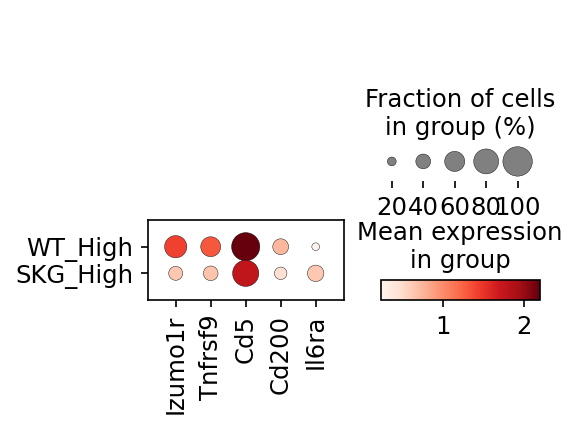

In [16]:
sc.pl.dotplot(adata_df_enriched, ['Izumo1r','Tnfrsf9','Cd5','Cd200','Il6ra'], 'subgroup')

# Differential expression SKG High TRBV enriched versus non-enriched

In [28]:
sag_trbv = ['TRBV26', 'TRBV12-1', 'TRBV15', 'TRBV16','TRBV3', 'TRBV29']
adata.obs['trbv_enriched'] = ['Enriched' if y in sag_trbv else 'Not enriched' for y in adata.obs['TRBV']]
adata_skg = adata[adata.obs['subgroup'] == 'SKG_High']
adata_skg

View of AnnData object with n_obs × n_vars = 19447 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb', 'trbv_enriched'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [31]:
sc.tl.rank_genes_groups(adata_skg, 'trbv_enriched', n_genes = len(adata_skg.raw.var_names), use_raw=True, groups='all',
                           reference='rest', rankby_abs=False, key_added=None,
                           copy=False, method='wilcoxon',
                           corr_method='benjamini-hochberg', log_transformed=True, pts = True)

ranking genes


/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_070222/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:35)


In [32]:
percent_df = adata_skg.uns['rank_genes_groups']['pts']
cluster = 'Enriched'

result_gene_names =  np.array(adata_skg.uns['rank_genes_groups']['names'][cluster])
result_log_changes = np.array(adata_skg.uns['rank_genes_groups']['logfoldchanges'][cluster])
result_p_values = np.array(adata_skg.uns['rank_genes_groups']['pvals_adj'][cluster])
result_df = pd.DataFrame.from_dict({'gene':result_gene_names,'logfoldchange':result_log_changes, 'adj_p_value':result_p_values})
result_df.index = result_df['gene']
result_df['Enriched_percent'] = list(percent_df.loc[result_df.index,:]['Enriched'])
result_df['Not_enriched_percent'] = list(percent_df.loc[result_df.index,:]['Not enriched'])

min_cutoff = 0.01
result_df_subset = result_df[[x > min_cutoff or y > min_cutoff for x,y in zip(result_df['Enriched_percent'],result_df['Not_enriched_percent'])]]
result_df_subset.to_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_all_cells_SKG_High_Enriched_versus_Non_Enriched_TRBV.csv')

# Differential expression WT High TRBV enriched versus non-enriched

In [33]:
adata_wt = adata[adata.obs['subgroup'] == 'WT_High']
adata_wt

View of AnnData object with n_obs × n_vars = 23498 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb', 'trbv_enriched'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [34]:
sc.tl.rank_genes_groups(adata_wt, 'trbv_enriched', n_genes = len(adata_wt.raw.var_names), use_raw=True, groups='all',
                           reference='rest', rankby_abs=False, key_added=None,
                           copy=False, method='wilcoxon',
                           corr_method='benjamini-hochberg', log_transformed=True, pts = True)

ranking genes


/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_070222/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:47)


In [35]:
percent_df = adata_wt.uns['rank_genes_groups']['pts']
cluster = 'Enriched'

result_gene_names =  np.array(adata_wt.uns['rank_genes_groups']['names'][cluster])
result_log_changes = np.array(adata_wt.uns['rank_genes_groups']['logfoldchanges'][cluster])
result_p_values = np.array(adata_wt.uns['rank_genes_groups']['pvals_adj'][cluster])
result_df = pd.DataFrame.from_dict({'gene':result_gene_names,'logfoldchange':result_log_changes, 'adj_p_value':result_p_values})
result_df.index = result_df['gene']
result_df['Enriched_percent'] = list(percent_df.loc[result_df.index,:]['Enriched'])
result_df['Not_enriched_percent'] = list(percent_df.loc[result_df.index,:]['Not enriched'])

min_cutoff = 0.01
result_df_subset = result_df[[x > min_cutoff or y > min_cutoff for x,y in zip(result_df['Enriched_percent'],result_df['Not_enriched_percent'])]]
result_df_subset.to_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_all_cells_WT_High_Enriched_versus_Non_Enriched_TRBV.csv')

# Volcano Plot Nr4a1 high cluster TRBV enriched WT High versus SKG High

In [2]:
result_df_subset = pd.read_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_Nr4a1_high_cluster_WT_High_Enriched_versus_SKG_High_Enriched_TRBV.csv')

In [3]:
result_df_subset['logfoldchange_rev'] = -result_df_subset['logfoldchange']
result_df_subset

,gene,gene.1,logfoldchange,adj_p_value,WT_High_percent,SKG_High_percent,logfoldchange_rev
0,Trbv29,Trbv29,3.115309,1.726070e-22,0.746939,0.245675,-3.115309
1,Izumo1r,Izumo1r,1.843240,5.415413e-11,0.685714,0.370242,-1.843240
2,Ephx1,Ephx1,1.339120,3.717110e-09,0.710204,0.467128,-1.339120
3,Tmem181a,Tmem181a,2.591706,3.717110e-09,0.465306,0.145329,-2.591706
4,Gm10260,Gm10260,1.444616,9.110107e-09,0.640816,0.470588,-1.444616
...,...,...,...,...,...,...,...
9903,Rnaset2a,Rnaset2a,-1.209654,5.332198e-07,0.432653,0.685121,1.209654
9904,Igfbp4,Igfbp4,-2.089085,9.078710e-08,0.236735,0.532872,2.089085
9905,Limd2,Limd2,-0.792917,3.717110e-09,0.873469,0.982699,0.792917
9906,Arf5,Arf5,-1.863100,3.717110e-09,0.228571,0.557093,1.863100


In [25]:
result_df_subset.sort_values('logfoldchange')

,gene,gene.1,logfoldchange,adj_p_value,WT_High_percent,SKG_High_percent,logfoldchange_rev,logpvalue
8436,Trbv26,Trbv26,-26.798880,1.0,0.000000,0.044983,26.798880,-0.0
8275,Pomk,Pomk,-25.454288,1.0,0.000000,0.041522,25.454288,-0.0
7870,Frmd4b,Frmd4b,-25.307875,1.0,0.000000,0.034602,25.307875,-0.0
7872,Dgat1,Dgat1,-25.275810,1.0,0.000000,0.034602,25.275810,-0.0
7067,Prrt2,Prrt2,-25.014256,1.0,0.000000,0.024221,25.014256,-0.0
...,...,...,...,...,...,...,...,...
1107,Cit,Cit,24.899290,1.0,0.024490,0.000000,-24.899290,-0.0
1316,Tceal3,Tceal3,24.925777,1.0,0.020408,0.000000,-24.925777,-0.0
1106,Dhrs3,Dhrs3,24.998167,1.0,0.024490,0.000000,-24.998167,-0.0
1108,Dgkg,Dgkg,25.076984,1.0,0.024490,0.000000,-25.076984,-0.0


In [7]:
np.max(result_df_subset['logfoldchange_rev'] )

26.79888

In [8]:
np.min(result_df_subset['logfoldchange_rev'] )

-25.104984

In [34]:
!pwd

/wynton/group/ye/emccarthy/EM/judy_proj/final_code


['Trbv29', 'Izumo1r', 'Il6ra', 'Tnfrsf9', 'Cd28', 'Junb', 'Cd5', 'B4galnt1', 'Foxo1', 'Cd3g', 'Ifngr2', 'Trbv16']


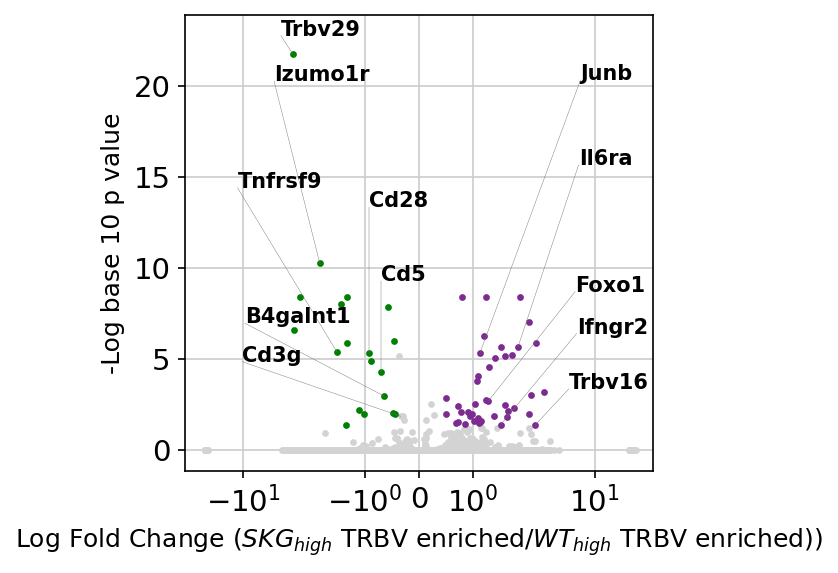

In [42]:
file_save_prefix = "results/single_cell_RNA_seq/"
result_df_subset['logpvalue'] = [-np.log10(x) for x in result_df_subset['adj_p_value']]
data_to_plot = result_df_subset
data_to_plot = data_to_plot.sort_values("logpvalue", ascending = False)
plt.rc('axes', axisbelow=True)

color_values = {(True,True, True):"#7c2b90", (False, True, True): "green"}
colors = [color_values.get((x > 0, abs(x) > 0.4, y > -np.log10(0.05)), "lightgrey") for x,y in zip(data_to_plot['logfoldchange_rev'], data_to_plot['logpvalue'])]
for color in ['lightgrey',"#7c2b90", "green"]:
    subset_data = data_to_plot[[x == color for x in colors]]
    plt.scatter(list(subset_data['logfoldchange_rev']),list(subset_data['logpvalue']), s = 5, edgecolors=color, color =  color)
    
    
plt.xlim((-40, 40)) 
plt.xscale('symlog')
#ax.setxticks(labels = ['-10','1','0','1','10'])
plt.xlabel("Log Fold Change ($SKG_{high}$ TRBV enriched/$WT_{high}$ TRBV enriched))", size = 12)
plt.ylabel("-Log base 10 p value", size = 12)

x = [i for i in data_to_plot['logfoldchange_rev']]
y = [i for i in data_to_plot['logpvalue']]
labels_orig = data_to_plot["gene"]

genes_to_label_left = ["Trbv29","Izumo1r", "Tnfrsf9", "Cd28","Cd5","B4galnt1","Cd3g","Junb"]

genes_to_label_right = ["Junb","Foxo1","Ifngr2","Il6ra","Trbv16"]



genes_to_label = genes_to_label_left  + genes_to_label_right

to_keep = np.where([i in genes_to_label for i in labels_orig])[0]
labels = list(np.array(labels_orig)[to_keep])
print(labels)
x = list(np.array(x)[to_keep])
y = list(np.array(y)[to_keep])


right_horiz_coord_list = np.array([5.5,3.5,5,4,3,2,2,5,6.5])
right_vert_coord_list = np.array([310,310,290, 290,255,220,165,120,160])

y_coord = {'Trbv29':1, 'Izumo1r':10, 'Tnfrsf9':9, 'Cd28':8,  'Cd5':5, 'B4galnt1':4, 
 'Cd3g':3, 'Il6ra':10, 'Junb':15, 'Foxo1':6, 'Ifngr2':5, 'Trbv16':2, 'Trbv31':5}
x_coord = {'Trbv29':1, 'Izumo1r':3, 'Tnfrsf9':10, 'Cd28':0,  'Cd5':0, 'B4galnt1':9, 
 'Cd3g':10,  'Il6ra':-5, 'Junb':-6, 'Foxo1':-5, 'Ifngr2':-5, 'Trbv16':-3, 'Trbv31':-10}

    
for i,txt in enumerate(labels):     
        
    plt.plot([x[i],x[i] - x_coord.get(txt,-1)],[y[i],y[i] + y_coord.get(txt,5)], color = "#6D6E71", linewidth = 0.2)
    t = plt.annotate(txt, (x[i] - x_coord.get(txt,-1), y[i] + y_coord.get(txt,5)), size = 10, weight="bold")

    
plt.savefig(file_save_prefix + "SKG_high_all_cells_TRBV_enriched_versus_WT_high_TRBV_enriched_volcano_plot_080824.svg", format="svg")



plt.show()
plt.close()

# Volcano Plot SKG High TRBV enriched versus non-enriched

In [33]:
result_df_subset = pd.read_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_all_cells_SKG_High_Enriched_versus_Non_Enriched_TRBV.csv')

In [3]:
result_df_subset

,gene,gene.1,logfoldchange,adj_p_value,Enriched_percent,Not_enriched_percent
0,Trbv29,Trbv29,5.711529,1.519819e-180,0.338033,0.019932
1,Trbv3,Trbv3,5.289493,1.167447e-177,0.339912,0.026638
2,Trbv16,Trbv16,4.900963,1.174478e-66,0.213033,0.018025
3,Trbv15,Trbv15,3.467267,1.355399e-11,0.105263,0.019994
4,Cd5,Cd5,0.237199,5.558932e-06,0.657581,0.620732
...,...,...,...,...,...,...
9468,Trbv19,Trbv19,-2.817831,2.177339e-18,0.036654,0.140265
9469,Trbv13-2,Trbv13-2,-1.564600,4.441260e-22,0.137218,0.239188
9470,Trbv13-1,Trbv13-1,-3.084539,1.109522e-22,0.036341,0.150600
9471,Trbv31,Trbv31,-2.722307,4.234949e-28,0.046053,0.171763


['Trbv29', 'Trbv3', 'Trbv16', 'Trbv5', 'Trbv31', 'Trbv13-1', 'Trbv13-2', 'Trbv19', 'Trbv1', 'Trbv15', 'Trbv4', 'Izumo1r', 'Trbv2', 'Trbv13-3', 'Trbv20']


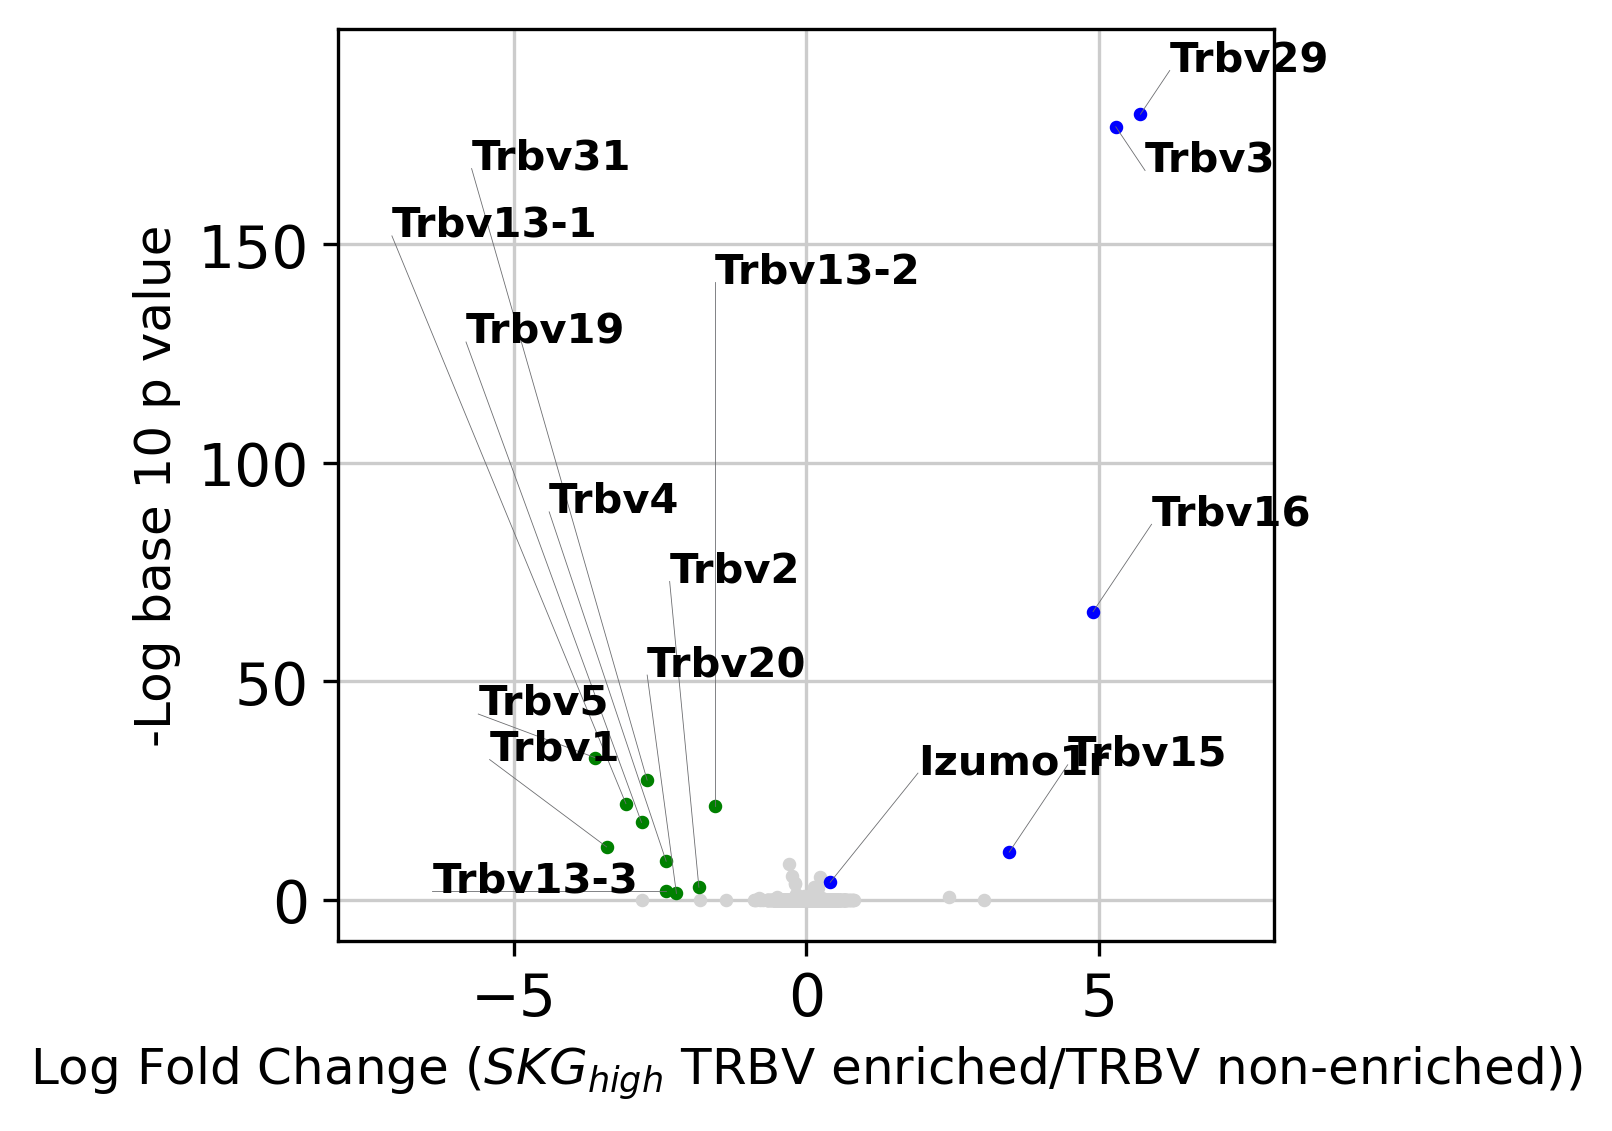

In [34]:
file_save_prefix = "results/single_cell_RNA_seq/"
result_df_subset['logpvalue'] = [-np.log10(x) for x in result_df_subset['adj_p_value']]
data_to_plot = result_df_subset
data_to_plot = data_to_plot.sort_values("logpvalue", ascending = False)
plt.rc('axes', axisbelow=True)

color_values = {(True,True, True):"blue", (False, True, True): "green"}
colors = [color_values.get((x > 0, abs(x) > 0.4, y > -np.log10(0.05)), "lightgrey") for x,y in zip(data_to_plot['logfoldchange'], data_to_plot['logpvalue'])]
for color in ['lightgrey',"blue", "green"]:
    subset_data = data_to_plot[[x == color for x in colors]]
    plt.scatter(list(subset_data['logfoldchange']),list(subset_data['logpvalue']), s = 5, edgecolors=color, color =  color)


plt.xlim((-8, 8)) 
plt.xlabel("Log Fold Change ($SKG_{high}$ TRBV enriched/TRBV non-enriched))", size = 12)
plt.ylabel("-Log base 10 p value", size = 12)

x = [i for i in data_to_plot['logfoldchange']]
y = [i for i in data_to_plot['logpvalue']]
labels_orig = data_to_plot["gene"]



genes_to_label_left = ["Trbv29","Trbv3", "Trbv16", "Trbv15"]

genes_to_label_right = ["Trbv13-2","Trbv2","Trbv20","Trbv13-3","Trbv4","Trbv31","Trbv19","Trbv13-1","Trbv1","Trbv5","Izumo1r"]





# genes_to_label_style_dic = {positive_color: ["normal","bold"], neutral_color:["italic","normal"], other_color:["normal","bold"], negative_color:["normal","bold"]}

# genes_to_label_color_dic = {"Gzma":["left",other_color],"Dntt":["left",other_color], "Ifit3":["left",other_color], "Socs3":["left",other_color], "Pdlim4":["left",other_color],"Thy1":["left",other_color], "Sell":["left",other_color],
#                            "Egr3":["right",positive_color],"Nr4a1":["right",positive_color],"eGFP":["right",positive_color],"Egr2":["right",positive_color],"Tnfrsf9":["right",positive_color],"Lad1":["right",neutral_color],
#                            "Pdcd1lg2":["right",negative_color],"Rgs16":["right",negative_color],"Irf4":["right",positive_color],"Cd83":["right",positive_color],"Nr4a3":["right",positive_color],
#                            "Mir155hg":["right",positive_color],"Egr1":["right",positive_color],"Alphl":["right",neutral_color],"Trpm1":["right",positive_color],"Arhgap200":["right",positive_color],
#                            "Nab2":["right",positive_color],"Marcksl1":["right",neutral_color],"Nfkbid":["right",positive_color],"Tnfrsf4":["right",positive_color],"Pdcd1":["right",negative_color],
#                             "Shmt1":["right",neutral_color],"Lag3":["right",negative_color],"Gm26828":["right",neutral_color],"Cd24a":["right",positive_color],"Cd160":["right",negative_color],
#                             "Trib1":["right",negative_color],"Myb":["right",positive_color],"Bcl2a1d":["right",positive_color]}


genes_to_label = genes_to_label_left  + genes_to_label_right

to_keep = np.where([i in genes_to_label for i in labels_orig])[0]
labels = list(np.array(labels_orig)[to_keep])
print(labels)
x = list(np.array(x)[to_keep])
y = list(np.array(y)[to_keep])


right_horiz_coord_list = np.array([5.5,3.5,5,4,3,2,2,5,6.5])
right_vert_coord_list = np.array([310,310,290, 290,255,220,165,120,160])

y_coord = {'Trbv29':10, 'Trbv3':-10, 'Trbv16':20, 'Trbv5':10, 'Trbv31':140, 'Trbv13-1':130, 'Trbv13-2':120, 'Trbv19':110, 
 'Trbv1':20, 'Trbv15':20, 'Trbv4':80, 'Trbv2':70, 'Trbv13-3':0, 'Trbv20':50,"Izumo1r":25}

x_coord = {'Trbv29':-0.5, 'Trbv3':-0.5, 'Trbv16':-1, 'Trbv5':2, 'Trbv31':3, 'Trbv13-1':4, 'Trbv13-2':0, 'Trbv19':3, 
 'Trbv1':2, 'Trbv15':-1, 'Trbv4':2, 'Trbv2':0.5, 'Trbv13-3':4, 'Trbv20':0.5,"Izumo1r":-1.5}

for i,txt in enumerate(labels):     
        
    plt.plot([x[i],x[i] - x_coord[txt]],[y[i],y[i] + y_coord[txt]], color = "#6D6E71", linewidth = 0.2)
    t = plt.annotate(txt, (x[i] - x_coord[txt], y[i] + y_coord[txt]), size = 10, weight="bold")
    
plt.savefig(file_save_prefix + "SKG_high_all_cells_TRBV_enriched_versus_non_enriched_volcano_plot_062824.svg", format="svg")



plt.show()
plt.close()

# Volcano Plot for WTHigh TRBV Enriched versus non-enriched

In [37]:
result_df_subset = pd.read_csv('results/single_cell_RNA_seq/differential_expression/diff_genes_all_cells_WT_High_Enriched_versus_Non_Enriched_TRBV.csv')

['Trbv29', 'Trbv3', 'Izumo1r', 'Cd5', 'Trbv13-2', 'Trbv5', 'Trbv16', 'Trbv31', 'Trbv13-1', 'Thy1', 'Id2', 'Trbv19', 'Igfbp4', 'Slamf6', 'Trbv1', 'Tnfrsf9', 'Cd200', 'Nr4a1', 'Trbv4', 'Trbv20', 'Tox', 'Ikzf2', 'Id3', 'Trbv2', 'Trbv13-3', 'Myb', 'Gm35363']


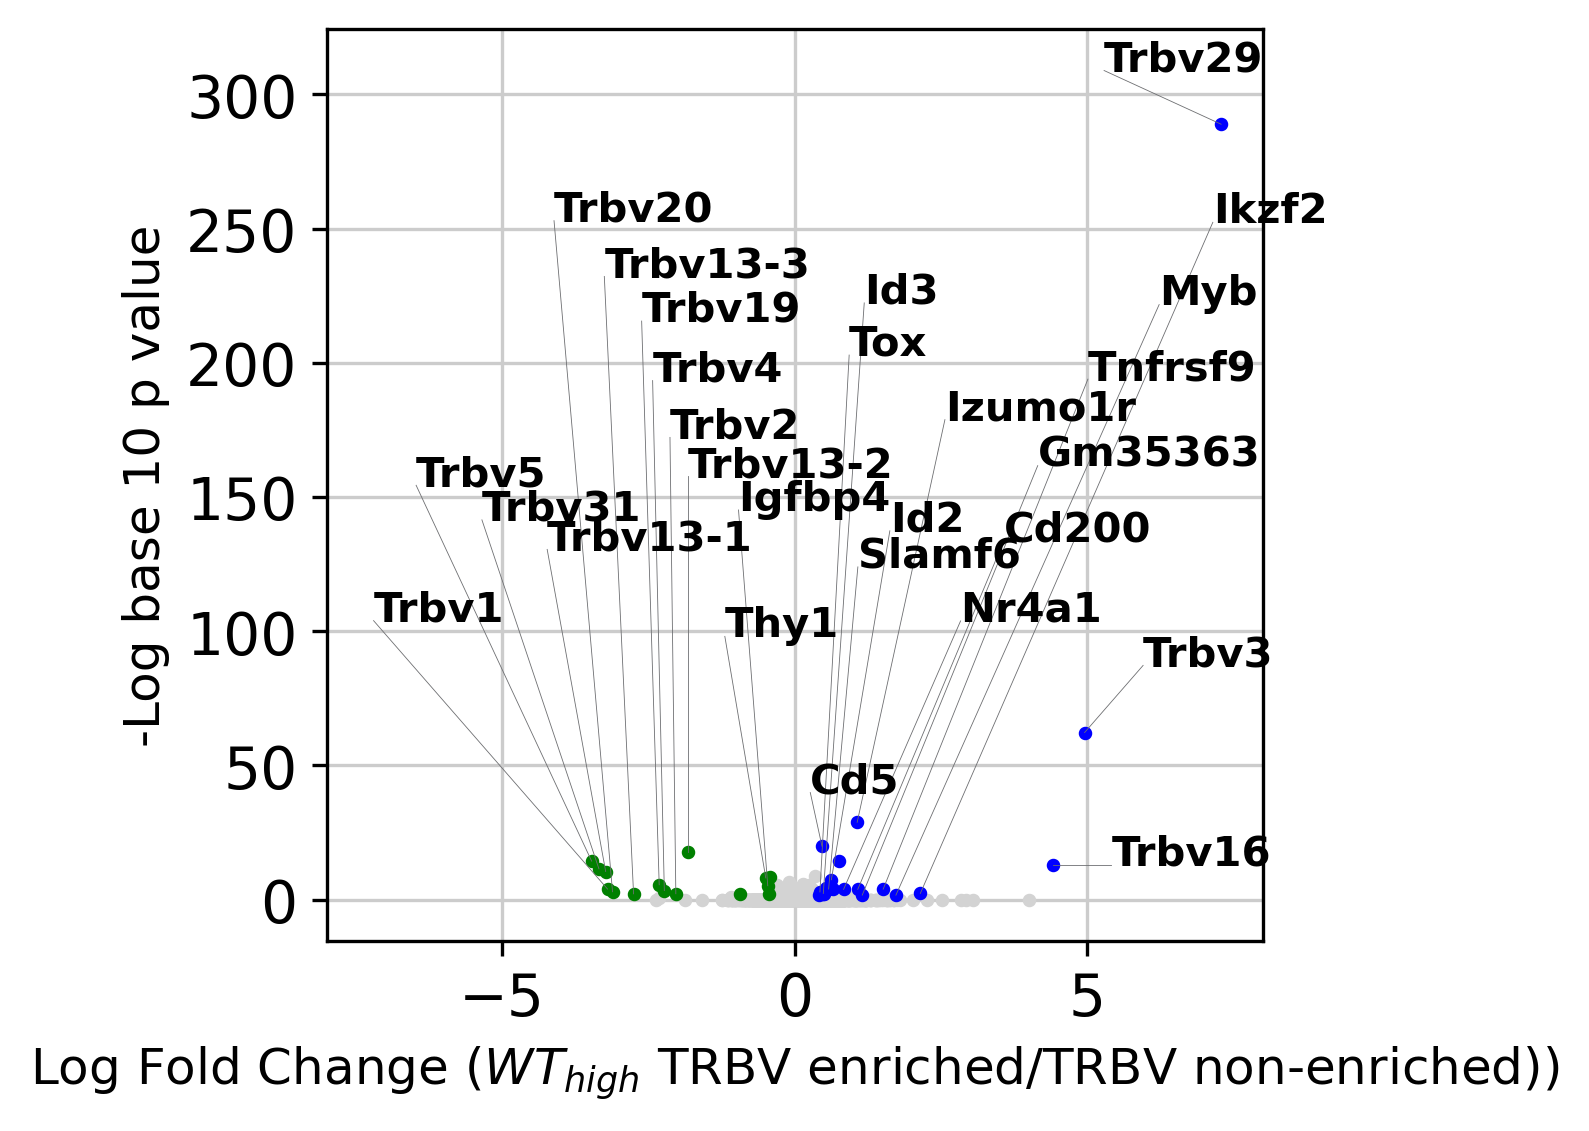

In [46]:
file_save_prefix = "results/single_cell_RNA_seq/"
result_df_subset['logpvalue'] = [-np.log10(x) for x in result_df_subset['adj_p_value']]
data_to_plot = result_df_subset
data_to_plot = data_to_plot.sort_values("logpvalue", ascending = False)
plt.rc('axes', axisbelow=True)

color_values = {(True,True, True):"blue", (False, True, True): "green"}
colors = [color_values.get((x > 0, abs(x) > 0.4, y > -np.log10(0.05)), "lightgrey") for x,y in zip(data_to_plot['logfoldchange'], data_to_plot['logpvalue'])]
for color in ['lightgrey',"blue", "green"]:
    subset_data = data_to_plot[[x == color for x in colors]]
    plt.scatter(list(subset_data['logfoldchange']),list(subset_data['logpvalue']), s = 5, edgecolors=color, color =  color)


plt.xlim((-8, 8)) 
plt.xlabel("Log Fold Change ($WT_{high}$ TRBV enriched/TRBV non-enriched))", size = 12)
plt.ylabel("-Log base 10 p value", size = 12)

x = [i for i in data_to_plot['logfoldchange']]
y = [i for i in data_to_plot['logpvalue']]
labels_orig = data_to_plot["gene"]

genes_to_label_left = ["Trbv29","Trbv3", "Trbv16", "Ikzf2","Myb","Tnfrsf9","Gm35363","Cd200","Izumo1r", 'Thy1','Igfbp4']

genes_to_label_right = ["Trbv13-2","Trbv2","Trbv4","Trbv19","Trbv13-3","Trbv20","Trbv1","Trbv13-1","Trbv31","Trbv5", 'Slamf6','Id2','Nr4a1', 'Tox','Cd5','Id3']





genes_to_label = genes_to_label_left  + genes_to_label_right

to_keep = np.where([i in genes_to_label for i in labels_orig])[0]
labels = list(np.array(labels_orig)[to_keep])
print(labels)
x = list(np.array(x)[to_keep])
y = list(np.array(y)[to_keep])

y_coord = {'Trbv29':20, 'Trbv3':25, 'Izumo1r':150, 'Trbv13-2':140, 'Trbv5':140, 'Trbv16':0, 'Trbv31':130, 'Trbv13-1':120, 'Trbv19':210, 
 'Trbv1':100, 'Tnfrsf9':190, 'Cd200':130, 'Trbv4':190, 'Trbv20':250, 'Ikzf2':250, 'Trbv2':170, 'Trbv13-3':230, 'Myb':220, 'Gm35363':160, 'Slamf6':120,'Id2':130,'Nr4a1':100,
          'Thy1':90,'Igfbp4':140, 'Tox':200,'Cd5':20,'Id3':220}

x_coord = {'Trbv29':2, 'Trbv3':-1, 'Izumo1r':-1.5, 'Trbv13-2':0, 'Trbv5':3, 'Trbv16':-1, 'Trbv31':2, 'Trbv13-1':1, 'Trbv19':0.3, 
 'Trbv1':4, 'Tnfrsf9':-3.5, 'Cd200':-2.5, 'Trbv4':0.2, 'Trbv20':1, 'Ikzf2':-5, 'Trbv2':0.1, 'Trbv13-3':0.5, 'Myb':-4.5, 'Gm35363':-3, 'Slamf6':-0.5,'Id2':-1,'Nr4a1':-2, 
           'Thy1':0.7,'Igfbp4':0.5,
         'Tox':-0.5,'Cd5':0.2,'Id3':-0.7 }



for i,txt in enumerate(labels):     
        
    plt.plot([x[i],x[i] - x_coord[txt]],[y[i],y[i] + y_coord[txt]], color = "#6D6E71", linewidth = 0.2)
    t = plt.annotate(txt, (x[i] - x_coord[txt], y[i] + y_coord[txt]), size = 10, weight="bold")
    
    # plt.plot([x[i],x[i] - 2],[y[i],y[i] + 50], color = "#6D6E71", linewidth = 0.2)
    # t = plt.annotate(txt, (x[i] - 2, y[i] + 50), size = 7, weight="bold")
    
plt.savefig(file_save_prefix + "WT_high_all_cells_TRBV_enriched_versus_non_enriched_volcano_plot_062824.svg", format="svg")



plt.show()
plt.close()

# Odds ratio plot for Tnfrsf9/Egr2 and TRBV Enriched/Non-enriched in WT High and SKG High

# Subset to Nr4a1 high cluster and add Tnfrsf9 and Egr2 annotation


In [4]:
adata_test = adata[adata.obs['cell_types'] == '3']
adata_test.obs['Tnf_cat'] = [(x>1, y>1) for x,y in zip(np.array(adata_test.raw[:,"Tnfrsf9"].X.todense()).ravel(),np.array(adata_test.raw[:,"Egr2"].X.todense()).ravel())]
conversion = {(False,False): "EgrnegTnfrsf9neg",(False,True):"Egr2 High", (True, False):"Tnfrsf9 High", (True,True):"EgrposTnfrsf9pos"}
adata_test.obs['Tnf_Egr_cat'] = [conversion[x] for x in adata_test.obs['Tnf_cat']]
adata_test = adata_test[[x in ['Egr2 High', 'Tnfrsf9 High'] and y in ['SKG_High','WT_High'] for x,y in zip(adata_test.obs['Tnf_Egr_cat'],adata_test.obs['subgroup'])]]
adata_test.obs['cat_subgroup'] = [x+" " + y for x,y in zip(adata_test.obs['subgroup'], adata_test.obs['Tnf_Egr_cat'])]
np.unique(adata_test.obs['cat_subgroup'])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


array(['SKG_High Egr2 High', 'SKG_High Tnfrsf9 High', 'WT_High Egr2 High',
       'WT_High Tnfrsf9 High'], dtype=object)

## Add enriched TRBV annotation

In [5]:
sag_trbv = ['TRBV26', 'TRBV12-1', 'TRBV15', 'TRBV16','TRBV3', 'TRBV29']
adata_test.obs['trbv_enriched_Tnf_Egr'] = ['Enriched_'+x if y in sag_trbv else 'Not enriched_'+x for x,y in zip(adata_test.obs['cat_subgroup'],adata_test.obs['TRBV'])]

## Combine TRBV annotation and subgroup

In [6]:
adata_test.obs['trbv_enriched_subgroup'] = ['Enriched_'+x if y in sag_trbv else 'Not enriched_'+x for x,y in zip(adata_test.obs['subgroup'],adata_test.obs['TRBV'])]
categories, amount = np.unique(adata_test.obs['trbv_enriched_subgroup'], return_counts = True)
cat_dict = {x:y for x,y in zip(categories, amount)}

In [7]:
cat_dict #2050

{'Enriched_SKG_High': 145,
 'Enriched_WT_High': 159,
 'Not enriched_SKG_High': 636,
 'Not enriched_WT_High': 1110}

In [8]:
adata_test

AnnData object with n_obs × n_vars = 2050 × 1119
    obs: 'GFP', 'RBC', 'batch', 'genotype', 'mouse', 'n_counts', 'n_genes', 'percent_mito', 'platelet', 'louvain', 'leiden', 'GFP_category', 'subgroup', 'umap_density_subgroup', 'cell_types', 'S_score', 'G2M_score', 'phase', 'module_1', 'module_2', 'module_3', 'module_4', 'module_5', 'module_6', 'TRAV', 'TRBV', 'clonotype', 'Biocarta_Nfkb', 'Tnf_cat', 'Tnf_Egr_cat', 'cat_subgroup', 'trbv_enriched_Tnf_Egr', 'trbv_enriched_subgroup'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcodes', 'genes', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'raw_counts', 'umap_density_subgroup_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
cat_dict

{'Enriched_SKG_High': 145,
 'Enriched_WT_High': 159,
 'Not enriched_SKG_High': 636,
 'Not enriched_WT_High': 1110}

In [10]:
import scipy.stats.contingency

## Create df for results and define OR function

In [41]:
adata_test.obs['trbv_enriched_subcluster'] = ['Enriched_'+x if y in sag_trbv else 'Not enriched_'+x for x,y in zip(adata_test.obs['Tnf_Egr_cat'],adata_test.obs['TRBV'])]
categories, amount = np.unique(adata_test.obs['trbv_enriched_subcluster'], return_counts = True)
cat_dict = {x:y for x,y in zip(categories, amount)}

In [38]:
df = pd.DataFrame(columns=['Group 1', 'Group 2', 'Enriched TRBV Group 1', 'Not enriched TRBV Group 1', 'Enriched TRBV Group 2',  'Not enriched TRBV Group 2', 'OR', 'low_CI','high_CI'], dtype=object)
print(df)

Empty DataFrame
Columns: [Group 1, Group 2, Enriched TRBV Group 1, Not enriched TRBV Group 1, Enriched TRBV Group 2, Not enriched TRBV Group 2, OR, low_CI, high_CI]
Index: []


In [42]:
cat_dict

{'Enriched_Egr2 High': 83,
 'Enriched_Tnfrsf9 High': 221,
 'Not enriched_Egr2 High': 487,
 'Not enriched_Tnfrsf9 High': 1259}

In [39]:
def calculate_odds_ratio(group1,group2,dictionary):
    a = dictionary['Enriched_'+group1]
    b = dictionary['Not enriched_'+group1]
    c = dictionary['Enriched_'+group2]
    d = dictionary['Not enriched_'+group2]
    table = np.array([[a, b], [c, d]])
    res = scipy.stats.contingency.odds_ratio(table, kind='sample')
    #return(res)
    return([group1, group2, a, b, c, d, res.statistic, res.confidence_interval()[0], res.confidence_interval()[1]]) 

## Final OR Plot

In [45]:
df.loc[len(df.index)] = calculate_odds_ratio('Tnfrsf9 High','Egr2 High', cat_dict)

In [46]:
df

,Group 1,Group 2,Enriched TRBV Group 1,Not enriched TRBV Group 1,Enriched TRBV Group 2,Not enriched TRBV Group 2,OR,low_CI,high_CI
0,Tnfrsf9 High,Egr2 High,221,1259,83,487,1.029953,0.783782,1.353441


In [47]:
categories, amount = np.unique(adata_test.obs['trbv_enriched_Tnf_Egr'], return_counts = True)
cat_dict = {x:y for x,y in zip(categories, amount)}

In [48]:
cat_dict

{'Enriched_SKG_High Egr2 High': 51,
 'Enriched_SKG_High Tnfrsf9 High': 94,
 'Enriched_WT_High Egr2 High': 32,
 'Enriched_WT_High Tnfrsf9 High': 127,
 'Not enriched_SKG_High Egr2 High': 178,
 'Not enriched_SKG_High Tnfrsf9 High': 458,
 'Not enriched_WT_High Egr2 High': 309,
 'Not enriched_WT_High Tnfrsf9 High': 801}

In [49]:
df.loc[len(df.index)] = calculate_odds_ratio('SKG_High Tnfrsf9 High','SKG_High Egr2 High', cat_dict)
df.loc[len(df.index)] = calculate_odds_ratio('WT_High Tnfrsf9 High','WT_High Egr2 High', cat_dict)
df

,Group 1,Group 2,Enriched TRBV Group 1,Not enriched TRBV Group 1,Enriched TRBV Group 2,Not enriched TRBV Group 2,OR,low_CI,high_CI
0,Tnfrsf9 High,Egr2 High,221,1259,83,487,1.029953,0.783782,1.353441
1,SKG_High Tnfrsf9 High,SKG_High Egr2 High,94,458,51,178,0.716328,0.488741,1.049894
2,WT_High Tnfrsf9 High,WT_High Egr2 High,127,801,32,309,1.531016,1.016777,2.305332


In [52]:
df.iloc[::-1]

,Group 1,Group 2,Enriched TRBV Group 1,Not enriched TRBV Group 1,Enriched TRBV Group 2,Not enriched TRBV Group 2,OR,low_CI,high_CI
2,WT_High Tnfrsf9 High,WT_High Egr2 High,127,801,32,309,1.531016,1.016777,2.305332
1,SKG_High Tnfrsf9 High,SKG_High Egr2 High,94,458,51,178,0.716328,0.488741,1.049894
0,Tnfrsf9 High,Egr2 High,221,1259,83,487,1.029953,0.783782,1.353441


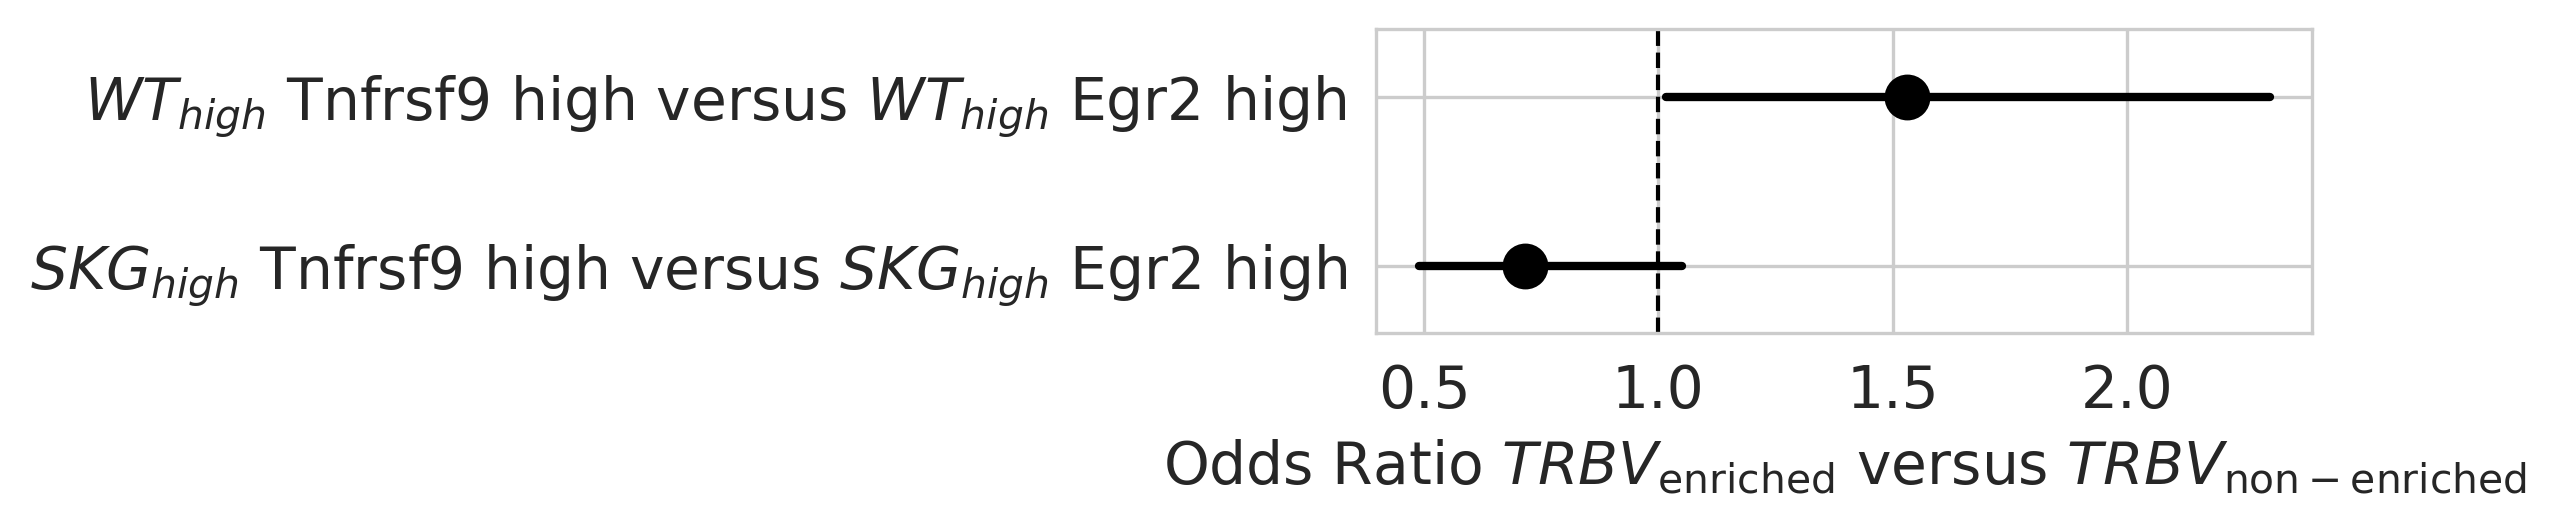

In [60]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(4, 2*2/3))
#ax.set_yscale("log")
ax.axvline(1, ls='--', linewidth=1, color='black')
plt.ylim(bottom = -0.2, top=0.7)
plt.yticks([0, 0.5])
n = 0
for index, i in df.iloc[[1,2],:].iterrows():
    x = [i["low_CI"], i["high_CI"]]
    #print(x)
    y = [n,n]
    ax.plot(x, y, "_-", markersize = 15, markeredgewidth= 0, linewidth = 2, color='black')

    y = [n]
    x = [i["OR"]]
    ax.plot(x, y, "o", color='black', markersize = 10)
    n += 0.5

ax.set_ylabel("")
ax.set_xlabel(r"Odds Ratio $TRBV_{\rm enriched}$ versus $TRBV_{\rm non-enriched}$")
ax.set_yticklabels(["$SKG_{high}$ Tnfrsf9 high versus $SKG_{high}$ Egr2 high", "$WT_{high}$ Tnfrsf9 high versus $WT_{high}$ Egr2 high" ])
file_save = 'results/single_cell_RNA_seq/JCI_revision/odds_ratio_enriched_TRBV_non_enriched_080224_two_rows.svg'

plt.savefig(file_save, format="svg", dpi = 300, bbox_inches = "tight")
plt.show()

# LME and barplots for protein MFI for Sag reactive versus non-Sag reactive

In [2]:
import statsmodels.formula.api as smf


In [3]:
df_mfi = pd.read_csv('data/sag_reactive_protein_mfi_raw_data_082224.csv')
df_mfi


,subgroup,protein,Sag-negative,Sag-reactive,Sag-negative.1,Sag-reactive.1,Sag-negative.2,Sag-reactive.2,Sag-negative.3,Sag-reactive.3,Sag-negative.4,Sag-reactive.4,Sag-negative.5,Sag-reactive.5,Sag-negative.6,Sag-reactive.6
0,SKG,41BB,142.0,141.0,144.0,141.0,147.0,145.0,50.4,51.4,48.9,49.3,49.8,50.6,NaN,NaN
1,WT,41BB,133.0,130.0,137.0,139.0,NaN,NaN,53.1,52.8,44.9,49.6,46.7,54.2,47.9,49.7
2,SKG,CD5,1287.0,2654.0,1472.0,2939.0,1278.0,2499.0,781.0,1594.0,937.0,2238.0,1014.0,2707.0,NaN,NaN
3,WT,CD5,2453.0,3760.0,2500.0,3747.0,NaN,NaN,1702.0,2568.0,1553.0,2912.0,1686.0,3025.0,1559.0,2749.0
4,SKG,CD200,175.0,232.0,199.0,226.0,179.0,206.0,139.0,169.0,161.0,208.0,127.0,157.0,NaN,NaN
5,WT,CD200,147.0,176.0,150.0,190.0,NaN,NaN,80.1,100.0,81.0,96.9,87.9,117.0,83.4,107.0
6,SKG,LAG-3,20.6,39.7,18.3,34.2,21.5,36.4,32.2,127.0,24.0,34.3,24.1,39.3,NaN,NaN
7,WT,LAG-3,21.2,31.8,20.4,35.1,NaN,NaN,26.0,133.0,22.5,31.0,23.0,35.1,22.9,34.1
8,SKG,CD73,547.0,782.0,522.0,659.0,495.0,532.0,749.0,953.0,935.0,1178.0,918.0,1107.0,NaN,NaN
9,WT,CD73,340.0,418.0,397.0,490.0,NaN,NaN,331.0,427.0,425.0,522.0,409.0,486.0,383.0,488.0


In [17]:
df_mfi.columns

Index(['subgroup', 'protein', 'Sag-negative', 'Sag-reactive', 'Sag-negative.1',
       'Sag-reactive.1', 'Sag-negative.2', 'Sag-reactive.2', 'Sag-negative.3',
       'Sag-reactive.3', 'Sag-negative.4', 'Sag-reactive.4', 'Sag-negative.5',
       'Sag-reactive.5', 'Sag-negative.6', 'Sag-reactive.6'],
      dtype='object')

In [4]:
machine_dict = {'Sag-negative':'cytometer 1', 'Sag-reactive':'cytometer 1', 'Sag-negative.1':'cytometer 1',
       'Sag-reactive.1':'cytometer 1', 'Sag-negative.2':'cytometer 1', 'Sag-reactive.2':'cytometer 1', 
 'Sag-negative.3':'cytometer 2', 'Sag-reactive.3':'cytometer 2', 'Sag-negative.4':'cytometer 2', 'Sag-reactive.4':'cytometer 2', 'Sag-negative.5':'cytometer 2',
       'Sag-reactive.5':'cytometer 2', 'Sag-negative.6':'cytometer 2', 'Sag-reactive.6':'cytometer 2'}

In [5]:
df_mfi_melt = pd.melt(df_mfi, id_vars=['subgroup','protein'], value_vars=df_mfi.columns[['Sag' in x for x in df_mfi.columns]])
df_mfi_melt['sag'] = ['Sag-negative' if 'neg' in x else 'Sag-reactive' for x in df_mfi_melt['variable']]

df_mfi_melt['subgroup_sag'] = [x + '_' + y for x,y in zip(df_mfi_melt['subgroup'],df_mfi_melt['sag'])]
df_mfi_melt

,subgroup,protein,variable,value,sag,subgroup_sag
0,SKG,41BB,Sag-negative,142.0,Sag-negative,SKG_Sag-negative
1,WT,41BB,Sag-negative,133.0,Sag-negative,WT_Sag-negative
2,SKG,CD5,Sag-negative,1287.0,Sag-negative,SKG_Sag-negative
3,WT,CD5,Sag-negative,2453.0,Sag-negative,WT_Sag-negative
4,SKG,CD200,Sag-negative,175.0,Sag-negative,SKG_Sag-negative
...,...,...,...,...,...,...
163,WT,LAG-3,Sag-reactive.6,34.1,Sag-reactive,WT_Sag-reactive
164,SKG,CD73,Sag-reactive.6,NaN,Sag-reactive,SKG_Sag-reactive
165,WT,CD73,Sag-reactive.6,488.0,Sag-reactive,WT_Sag-reactive
166,SKG,FR4,Sag-reactive.6,NaN,Sag-reactive,SKG_Sag-reactive


In [6]:
df_mfi_melt['flow_machine'] = [machine_dict[x] for x in df_mfi_melt['variable']]

In [7]:
mouse_dict = {'Sag-negative':'mouse 1', 'Sag-reactive':'mouse 1', 'Sag-negative.1':'mouse 2',
       'Sag-reactive.1':'mouse 2', 'Sag-negative.2':'mouse 3', 'Sag-reactive.2':'mouse 3', 
 'Sag-negative.3':'mouse 4', 'Sag-reactive.3':'mouse 4', 'Sag-negative.4':'mouse 5', 'Sag-reactive.4':'mouse 5', 'Sag-negative.5':'mouse 6',
       'Sag-reactive.5':'mouse 6', 'Sag-negative.6':'mouse 7', 'Sag-reactive.6':'mouse 7'}

In [8]:
df_mfi_melt['mouse'] = [mouse_dict[x] for x in df_mfi_melt['variable']]

In [9]:
df_mfi_melt = df_mfi_melt.dropna(axis = 0)


In [10]:
df_mfi_melt

,subgroup,protein,variable,value,sag,subgroup_sag,flow_machine,mouse
0,SKG,41BB,Sag-negative,142.0,Sag-negative,SKG_Sag-negative,cytometer 1,mouse 1
1,WT,41BB,Sag-negative,133.0,Sag-negative,WT_Sag-negative,cytometer 1,mouse 1
2,SKG,CD5,Sag-negative,1287.0,Sag-negative,SKG_Sag-negative,cytometer 1,mouse 1
3,WT,CD5,Sag-negative,2453.0,Sag-negative,WT_Sag-negative,cytometer 1,mouse 1
4,SKG,CD200,Sag-negative,175.0,Sag-negative,SKG_Sag-negative,cytometer 1,mouse 1
...,...,...,...,...,...,...,...,...
159,WT,CD5,Sag-reactive.6,2749.0,Sag-reactive,WT_Sag-reactive,cytometer 2,mouse 7
161,WT,CD200,Sag-reactive.6,107.0,Sag-reactive,WT_Sag-reactive,cytometer 2,mouse 7
163,WT,LAG-3,Sag-reactive.6,34.1,Sag-reactive,WT_Sag-reactive,cytometer 2,mouse 7
165,WT,CD73,Sag-reactive.6,488.0,Sag-reactive,WT_Sag-reactive,cytometer 2,mouse 7


In [ ]:
#Plot data
sns.set_theme(style='white')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
for protein in np.unique(df_mfi_melt['protein']):
    fig, ax = plt.subplots(figsize = (2,2))
    #sns.set_theme(rc={'figure.figsize':(1,1)})
    bar = sns.barplot(data = df_mfi_melt[[x == protein for x in df_mfi_melt['protein']]], x='subgroup_sag', y='value', color = 'grey', hue = 'flow_machine',  
                order = ["WT_Sag-negative","WT_Sag-reactive", "SKG_Sag-negative","SKG_Sag-reactive"], errwidth = 1, errorbar='se',capsize = 0.2, errcolor = 'black', 
                ax = ax)
    sns.stripplot(data = df_mfi_melt[[x == protein for x in df_mfi_melt['protein']]], x='subgroup_sag', y='value', hue = 'flow_machine', palette = ["white","white"], edgecolor = 'black', linewidth = 1,
                                order = ["WT_Sag-negative","WT_Sag-reactive","SKG_Sag-negative","SKG_Sag-reactive"], jitter=True,
                                dodge=True)
    plt.xticks(ticks = [0,1,2,3], labels = [" WT ","","SKG", ""],fontsize = 10)
    #locs, labels = xticks()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('MFI')
    plt.xlabel('')
    plt.title(protein)
    colors = ['green','#7C2B90','green', '#7C2B90', 'green',   '#7C2B90',  'green','#7C2B90','green','#7C2B90','green', '#7C2B90', 'green',   '#7C2B90',  'green','#7C2B90' ]
    hatches = ['','','','','/','/','/','/', '','','','','/','/','/','/']

    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
       
        thisbar.set_color(colors[i])
        thisbar.set_edgecolor("black")
        thisbar.set_hatch(hatches[i])

        
    file_save_prefix = "results/single_cell_RNA_seq/"
    ax.get_legend().remove()
    
    plt.savefig(file_save_prefix + "barplot_sag_neg_sag_reactive_protein_MFI_082524_" + protein +".png", format="png")

    plt.show()
    plt.close()

In [60]:
def lme_MFI_unpaired(df):
    my_model_fit = smf.mixedlm('value ~ subgroup ', re_formula='1', groups='flow_machine', data=df_subset, missing='drop').fit()
    # get random effects
    my_model_fit.random_effects
    # get fixed effects
    print(my_model_fit.summary())
    return(my_model_fit.params[1], my_model_fit.pvalues[1])

In [67]:
def lme_MFI_paired(df):
    my_model_fit = smf.mixedlm('value ~ sag + mouse', re_formula='1', groups='flow_machine', data=df_subset, missing='drop').fit()
    # get random effects
    my_model_fit.random_effects
    # get fixed effects
    print(my_model_fit.summary())
    return(my_model_fit.params[1], my_model_fit.pvalues[1])

In [71]:
pairings = [['paired','WT', 'Sag-negative', 'WT','Sag-reactive'],
 ['paired','SKG', 'Sag-negative', 'SKG','Sag-reactive'],
  ['unpaired','SKG', 'Sag-reactive', 'WT','Sag-reactive'],
   ['unpaired','SKG', 'Sag-negative', 'WT','Sag-negative']]
p_values = list()
effect_sizes = list()
index_list = list()
pair_list = list()
for marker in np.unique(df_mfi_melt['protein']):
    for pair in pairings:
        
        df_subset = df_mfi_melt[[x == marker and (y == pair[1] + '_' + pair[2] or y == pair[3] + '_'  + pair[4]) for x,y in zip(df_mfi_melt['protein'],df_mfi_melt['subgroup_sag'])]]

        if pair[0] == 'paired':
            print(marker,pair[1]+'_'+pair[2]+'_'+pair[3]+'_'+pair[4], "lme paired")
            print(df_subset)
            effect_size, p_value = lme_MFI_paired(df_subset)
      
        if pair[0] == 'unpaired':
            print(marker,pair[1]+'_'+pair[2]+'_'+pair[3]+'_'+pair[4], "lme unpaired")
            print(df_subset)
            effect_size, p_value = lme_MFI_unpaired(df_subset)
        effect_sizes = effect_sizes + [effect_size]
        p_values = p_values + [p_value]
        index_list = index_list + [marker + '_' +pair[1]+'_'+pair[2]+'_'+pair[3]+'_'+pair[4] ]
        pair_list = pair_list + [str(pair[0])]
        
result_df = pd.DataFrame(list(zip(pair_list, p_values,effect_sizes)), columns = ['paired','p_value','effect_size'], index = index_list)

41BB WT_Sag-negative_WT_Sag-reactive lme paired
    subgroup protein        variable  value           sag     subgroup_sag  \
1         WT    41BB    Sag-negative  133.0  Sag-negative  WT_Sag-negative   
13        WT    41BB    Sag-reactive  130.0  Sag-reactive  WT_Sag-reactive   
25        WT    41BB  Sag-negative.1  137.0  Sag-negative  WT_Sag-negative   
37        WT    41BB  Sag-reactive.1  139.0  Sag-reactive  WT_Sag-reactive   
73        WT    41BB  Sag-negative.3   53.1  Sag-negative  WT_Sag-negative   
85        WT    41BB  Sag-reactive.3   52.8  Sag-reactive  WT_Sag-reactive   
97        WT    41BB  Sag-negative.4   44.9  Sag-negative  WT_Sag-negative   
109       WT    41BB  Sag-reactive.4   49.6  Sag-reactive  WT_Sag-reactive   
121       WT    41BB  Sag-negative.5   46.7  Sag-negative  WT_Sag-negative   
133       WT    41BB  Sag-reactive.5   54.2  Sag-reactive  WT_Sag-reactive   
145       WT    41BB  Sag-negative.6   47.9  Sag-negative  WT_Sag-negative   
157       WT    

/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    value   
No. Observations:      12         Method:                REML    
No. Groups:            2          Scale:                 79.5333 
Min. group size:       6          Log-Likelihood:        -20.6639
Max. group size:       6          Converged:             Yes     
Mean group size:       6.0                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           185.333   11.222 16.516 0.000 163.339 207.328
sag[T.Sag-reactive]  36.333    5.149  7.057 0.000  26.242  46.425
mouse[T.mouse 2]      9.000    8.918  1.009 0.313  -8.479  26.479
mouse[T.mouse 3]    -11.000    8.918 -1.233 0.217 -28.479   6.479
mouse[T.mouse 4]    -49.500   15.447 -3.205 0.001 -79.775 -19.225
mouse[T.mouse 5]    -19.

/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value     
No. Observations:     12         Method:                REML      
No. Groups:           2          Scale:                 21656.8306
Min. group size:      5          Log-Likelihood:        -67.8730  
Max. group size:      7          Converged:             Yes       
Mean group size:      6.0                                         
------------------------------------------------------------------
                   Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
------------------------------------------------------------------
Intercept          1128.167  318.176  3.546 0.000 504.553 1751.780
subgroup[T.WT]      883.814   86.234 10.249 0.000 714.799 1052.829
flow_machine Var 195252.806 2016.505                              

CD73 WT_Sag-negative_WT_Sag-reactive lme paired
    subgroup protein        variable  value           sag     subgroup_sag  \
9         WT    C

/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/wynton/home/ye/emccarthy/miniconda3/envs/scanpy_032021/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    subgroup protein        variable  value           sag      subgroup_sag  \
22       SKG     FR4    Sag-reactive  556.0  Sag-reactive  SKG_Sag-reactive   
23        WT     FR4    Sag-reactive  564.0  Sag-reactive   WT_Sag-reactive   
46       SKG     FR4  Sag-reactive.1  382.0  Sag-reactive  SKG_Sag-reactive   
47        WT     FR4  Sag-reactive.1  543.0  Sag-reactive   WT_Sag-reactive   
70       SKG     FR4  Sag-reactive.2  345.0  Sag-reactive  SKG_Sag-reactive   
94       SKG     FR4  Sag-reactive.3  320.0  Sag-reactive  SKG_Sag-reactive   
95        WT     FR4  Sag-reactive.3  326.0  Sag-reactive   WT_Sag-reactive   
118      SKG     FR4  Sag-reactive.4  248.0  Sag-reactive  SKG_Sag-reactive   
119       WT     FR4  Sag-reactive.4  295.0  Sag-reactive   WT_Sag-reactive   
142      SKG     FR4  Sag-reactive.5  316.0  Sag-reactive  SKG_Sag-reactive   
143       WT     FR4  Sag-reactive.5  307.0  Sag-reactive   WT_Sag-reactive   
167       WT     FR4  Sag-reactive.6  365.0  Sag-rea

In [72]:
result_df['adj_p_value'] = statsmodels.stats.multitest.fdrcorrection(result_df.iloc[:,1])[1]

result_df_unpaired = result_df.loc[[str(x) == 'unpaired' for x in result_df['paired']],:]

result_df_unpaired.sort_values('adj_p_value')

,paired,p_value,effect_size,adj_p_value
CD5_SKG_Sag-negative_WT_Sag-negative,unpaired,1.194966e-24,883.814365,7.169797e-24
CD200_SKG_Sag-negative_WT_Sag-negative,unpaired,4.303323e-12,-49.764846,1.290997e-11
CD200_SKG_Sag-reactive_WT_Sag-reactive,unpaired,3.076692e-08,-58.918780,7.632842e-08
CD73_SKG_Sag-negative_WT_Sag-negative,unpaired,6.835021e-08,-341.906704,1.491277e-07
CD73_SKG_Sag-reactive_WT_Sag-reactive,unpaired,1.397191e-07,-431.118379,2.579429e-07
CD5_SKG_Sag-reactive_WT_Sag-reactive,unpaired,3.308769e-05,798.895270,5.672175e-05
FR4_SKG_Sag-negative_WT_Sag-negative,unpaired,4.862980e-04,70.148253,7.780769e-04
41BB_SKG_Sag-negative_WT_Sag-negative,unpaired,1.564036e-02,-4.762219,2.346054e-02
FR4_SKG_Sag-reactive_WT_Sag-reactive,unpaired,7.907660e-02,67.224196,1.054355e-01
41BB_SKG_Sag-reactive_WT_Sag-reactive,unpaired,2.423544e-01,-2.563321,2.769764e-01


In [73]:
result_df_paired = result_df.loc[[str(x) == 'paired' for x in result_df['paired']],:]

result_df_paired.sort_values('adj_p_value')

,paired,p_value,effect_size,adj_p_value
CD73_WT_Sag-negative_WT_Sag-reactive,paired,2.666834e-88,91.000000,6.400402e-87
CD5_WT_Sag-negative_WT_Sag-reactive,paired,1.424217e-59,1218.000000,1.709060e-58
CD5_SKG_Sag-negative_SKG_Sag-reactive,paired,6.649371e-28,1310.333333,5.319497e-27
CD200_WT_Sag-negative_WT_Sag-reactive,paired,3.299384e-14,26.250000,1.583704e-13
FR4_WT_Sag-negative_WT_Sag-reactive,paired,1.525981e-13,107.000000,6.103923e-13
CD200_SKG_Sag-negative_SKG_Sag-reactive,paired,1.707101e-12,36.333333,5.852917e-12
CD73_SKG_Sag-negative_SKG_Sag-reactive,paired,3.180351e-08,174.166667,7.632842e-08
FR4_SKG_Sag-negative_SKG_Sag-reactive,paired,1.196927e-07,118.166667,2.393855e-07
LAG-3_SKG_Sag-negative_SKG_Sag-reactive,paired,3.341929e-02,28.366667,4.718018e-02
LAG-3_WT_Sag-negative_WT_Sag-reactive,paired,8.642170e-02,27.350000,1.091643e-01


In [74]:
#result_df_unpaired.to_csv('results/Sag_reactive_Sag_negative_WT_SKG_surface_protein_markers_082524_unpaired_results_lme.csv')
#result_df_paired.to_csv('results/Sag_reactive_Sag_negative_WT_SKG_surface_protein_markers_082524_paired_results_lme.csv')